In [1]:
import glob
from pathlib import Path
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def create_model(base_model, classData):
    for layer in base_model.layers:
        layer.trainable = False
            
    top_model = base_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(classData, activation='softmax')(top_model)

    model = Model(inputs=base_model.input, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])        
            
    return model


train_path = '../aug_oversampling_v2_dataset/balanced_oversampling'
test_path  = '../aug_oversampling_v2_dataset/test_data'
IMG_SHAPE = (224, 224, 3)
batch_size = 32
classData = 10

base_model = MobileNetV3Large(
    include_top=False,
    alpha=1.0,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model = create_model(base_model, classData)
# model.summary()

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(224,224),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=batch_size
)

Found 10000 files belonging to 10 classes.
Using 9000 files for training.
Found 10000 files belonging to 10 classes.
Using 1000 files for validation.


In [3]:
#custom callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
282/282 [==============================] - 476s 2s/step - loss: 1.0996 - accuracy: 0.7110 - val_loss: 0.4536 - val_accuracy: 0.8820
Epoch 2/10
282/282 [==============================] - 464s 2s/step - loss: 0.0976 - accuracy: 0.9746 - val_loss: 0.3919 - val_accuracy: 0.9010
Epoch 3/10
282/282 [==============================] - 462s 2s/step - loss: 0.0387 - accuracy: 0.9914 - val_loss: 0.3823 - val_accuracy: 0.9020
Epoch 4/10
282/282 [==============================] - 462s 2s/step - loss: 0.0423 - accuracy: 0.9919 - val_loss: 0.4625 - val_accuracy: 0.8860
Epoch 5/10
282/282 [==============================] - 463s 2s/step - loss: 0.0357 - accuracy: 0.9938 - val_loss: 0.4085 - val_accuracy: 0.8980
Epoch 6/10
282/282 [==============================] - 463s 2s/step - loss: 0.0222 - accuracy: 0.9940 - val_loss: 0.4238 - val_accuracy: 0.8970


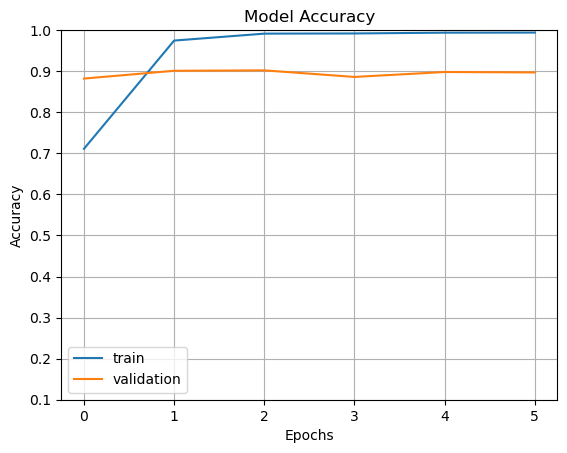

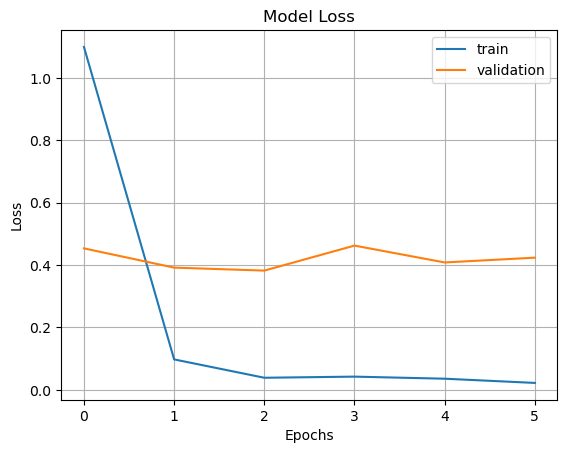

In [4]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
# axes[0].plot(x1, y1)
# axes[1].plot(x2, y2)

In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=1
)

predictions = model.predict(test_ds)

Found 1000 files belonging to 10 classes.
1000/1000 [==============================] - 98s 95ms/step


In [6]:
import numpy as np
from sklearn.metrics import classification_report

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names, digits=4))

                          precision    recall  f1-score   support

   bacterial_leaf_blight     0.8854    0.8500    0.8673       100
   bacterial_leaf_streak     1.0000    0.8800    0.9362       100
bacterial_panicle_blight     0.9432    0.8300    0.8830       100
                   blast     0.7876    0.8900    0.8357       100
              brown_spot     0.7982    0.9100    0.8505       100
              dead_heart     0.8716    0.9500    0.9091       100
            downy_mildew     0.8725    0.8900    0.8812       100
                   hispa     0.9881    0.8300    0.9022       100
                  normal     0.8990    0.8900    0.8945       100
                  tungro     0.8879    0.9500    0.9179       100

                accuracy                         0.8870      1000
               macro avg     0.8933    0.8870    0.8877      1000
            weighted avg     0.8933    0.8870    0.8877      1000



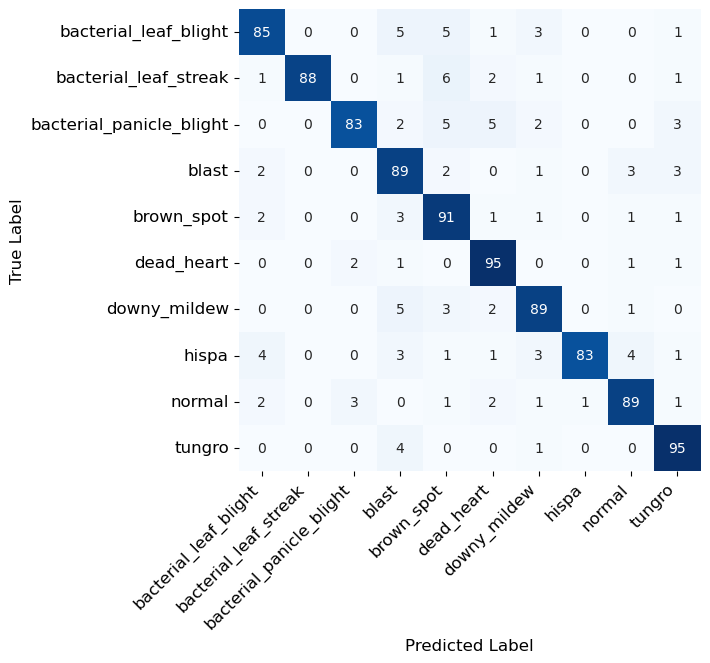

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="EfficientNetV2B0-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [8]:
model.save('PaddyDisease_MobileNetV3Large_OverSampling_224_v2.h5')